### Goal ("Revolving Door")

You belong to the people analytics team for a food conglomerate. Employee turnover has been rampant for your 10 subsidiaries. The CFO estimates that the cost of replacing an employee is often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months. Your team has been tasked with diagnosing why and when employees from your subsidiaries leave. You need a tangible data-driven recommendation for each of the ten Presidents of your subsidiaries. What are your recommendations and why?

### Challenge Description

We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are s'till at the company as of 2015/12/13 or they have quit. Beside that, we have general info
about the employee, such as average salary during her tenure, department, and years of experience. As said above, the goal is to predict employee retention and understand its main drivers

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('employee_retention.txt')

In [3]:
df.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34702 entries, 0 to 34701
Data columns (total 8 columns):
Unnamed: 0     34702 non-null int64
employee_id    34702 non-null float64
company_id     34702 non-null int64
dept           34702 non-null object
seniority      34702 non-null int64
salary         34463 non-null float64
join_date      34702 non-null object
quit_date      23510 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 2.1+ MB


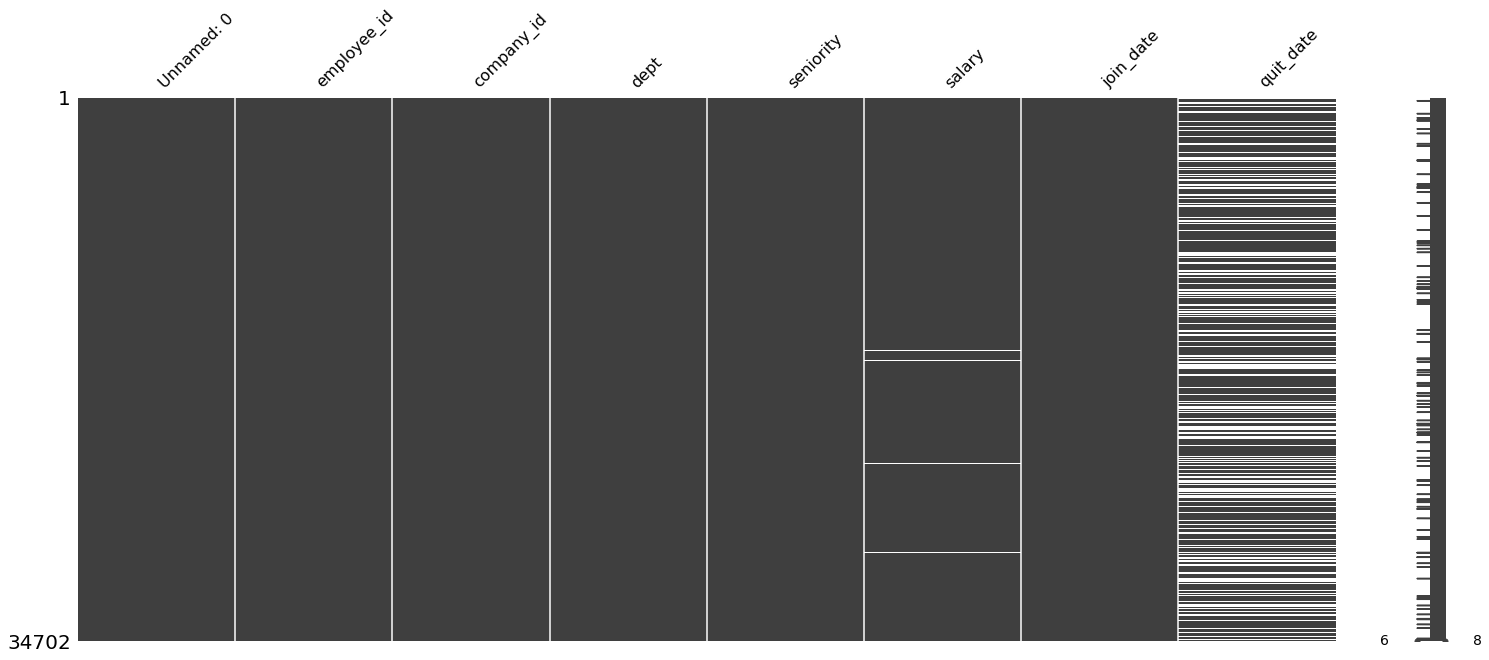

In [5]:
# Let's visually check for missing values
msno.matrix(df);

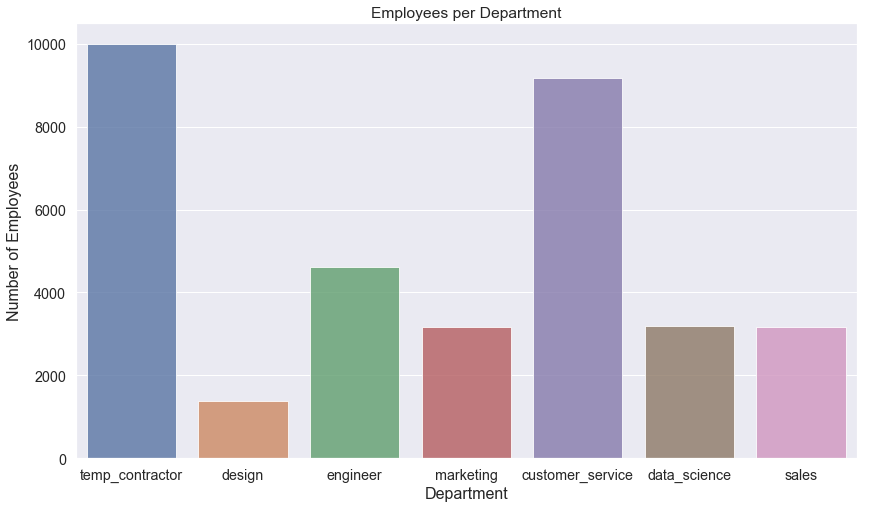

In [6]:
# We can also visualize the total number of employees for different departments

sns.set(font_scale=1.3)
plt.figure(figsize=(14,8))
sns.countplot(x='dept',data=df,alpha=0.8)
plt.ylabel('Number of Employees', fontsize=16)
plt.title('Employees per Department')
plt.xlabel('Department', fontsize=16);

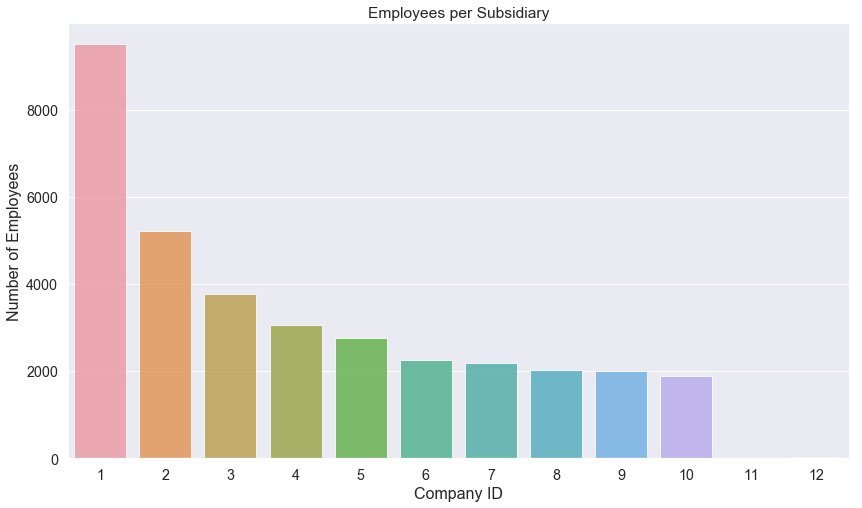

In [7]:
# How about the total number of employees who joined for each company?

sns.set(font_scale=1.3)
plt.figure(figsize=(14,8))
sns.countplot(x='company_id',data=df,alpha=0.8)
plt.ylabel('Number of Employees', fontsize=16)
plt.xlabel('Company ID', fontsize=16)
plt.title('Employees per Subsidiary');

In [8]:
# Let's create a new column 'Length' to track how long employees lasted in each company

df['quit_date'] = pd.to_datetime(df['quit_date'])
df['join_date'] = pd.to_datetime(df['join_date'])
df['Length'] = df['quit_date'] - df['join_date'];
df['Length']= df['Length'].astype('timedelta64[Y]');

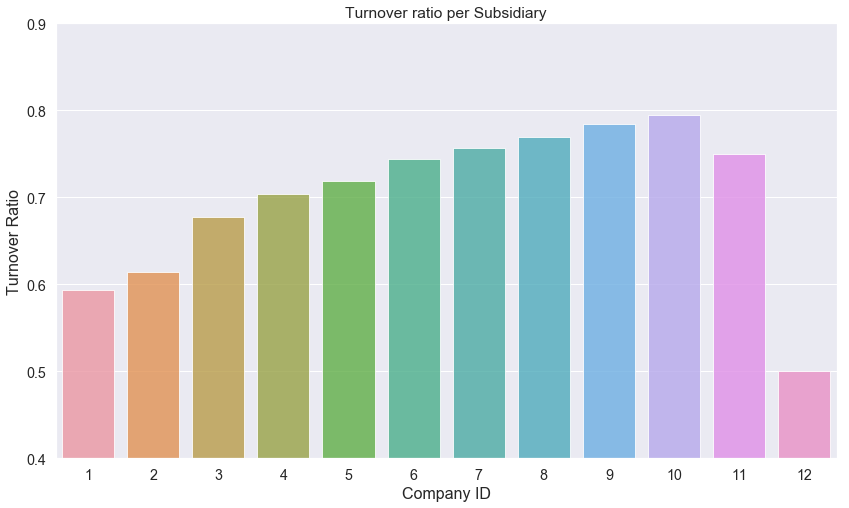

In [9]:
# Next, we can look at the proportion of employees who quit since raw numbers can be misleading

join_count = df.groupby('company_id').join_date.count()
quit_count = df.groupby('company_id').quit_date.count()
quit_ratio = quit_count / join_count

sns.set(font_scale=1.3)
plt.figure(figsize=(14,8))
sns.barplot(x=quit_ratio.index,y=quit_ratio,alpha=0.8)
plt.ylabel('Turnover Ratio', fontsize=16)
plt.xlabel('Company ID', fontsize=16)
plt.ylim(0.4,0.9)
plt.title('Turnover ratio per Subsidiary');

In [10]:
# We can also look at how long each employee stayed before quitting

df_quit = df[df['quit_date'].notnull()].copy()

Text(0.5, 1.0, 'Duration at Company by Department')

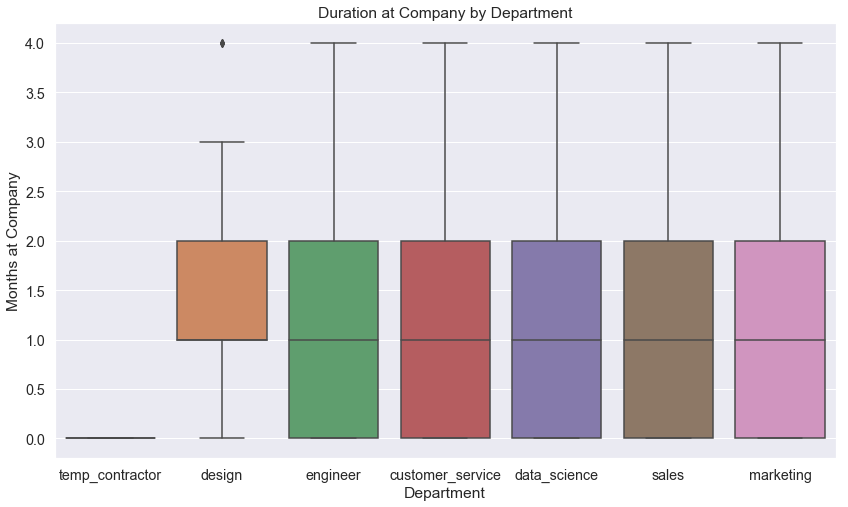

In [11]:
plt.figure(figsize=(14,8))
sns.boxplot(x = 'dept', y = 'Length', data = df_quit);
plt.ylabel('Months at Company');
plt.xlabel('Department');
plt.title('Duration at Company by Department')

In [12]:
# Since it looks like temp contractors have fixed length contracts, we can drop them and remake the plots

df_quit = df_quit[df_quit.dept != 'temp_contractor']

Text(0.5, 1.0, 'Duration at Company by Subsidiary')

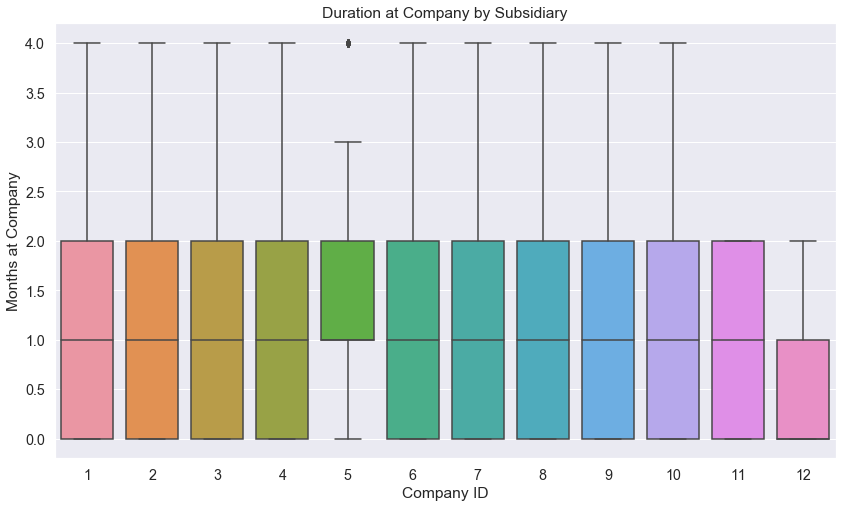

In [13]:
plt.figure(figsize=(14,8))
sns.boxplot(x = 'company_id', y = 'Length', data = df_quit);
plt.ylabel('Months at Company');
plt.xlabel('Company ID');
plt.title('Duration at Company by Subsidiary')

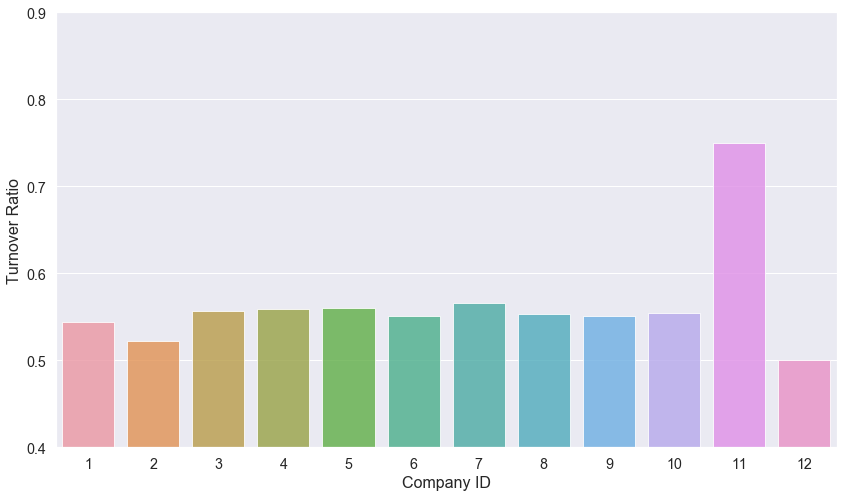

In [14]:
# Let's look at the turnover ratio again after removing the fixed-length contractors

join_count = df[df['dept'] != 'temp_contractor'].groupby('company_id').join_date.count()
quit_count = df[df['dept'] != 'temp_contractor'].groupby('company_id').quit_date.count()
quit_ratio = quit_count / join_count

sns.set(font_scale=1.3)
plt.figure(figsize=(14,8))
sns.barplot(x=quit_ratio.index,y=quit_ratio,alpha=0.8)
plt.ylabel('Turnover Ratio', fontsize=16)
plt.xlabel('Company ID', fontsize=16)
plt.ylim(0.4,0.9);

In [15]:
df2 = df[df['dept'] != 'temp_contractor']

Text(0.5, 1.0, 'Salary by Department')

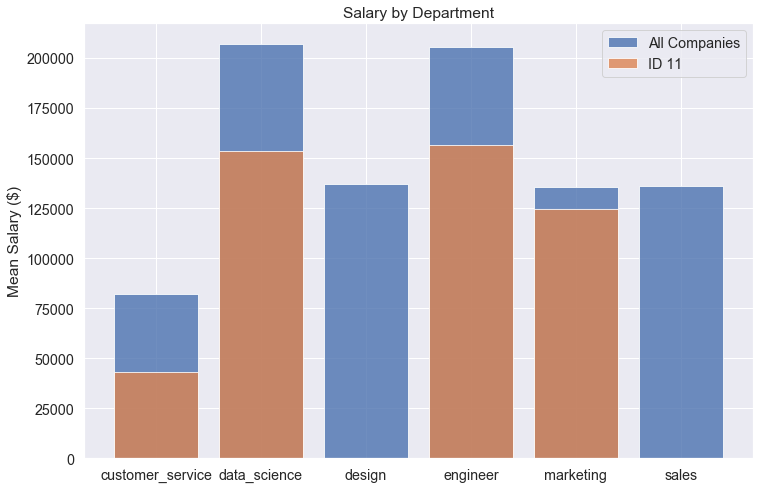

In [16]:
# Since Subsidiary 11 looked different from the rest, let's take a closer look. It looks like the employees there earn less than the mean.

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(list(df2.groupby('dept').groups.keys()),df2.groupby('dept').salary.mean(),alpha=0.8)
ax.bar(list(df2[df2['company_id'] == 11].groupby('dept').groups.keys()),df2[df2['company_id'] == 11].groupby('dept').salary.mean(),alpha=0.8);

plt.legend(['All Companies','ID 11'])
plt.ylabel('Mean Salary ($)')
plt.title('Salary by Department')

In [17]:
df3 = pd.concat([df2.drop(columns=['company_id','dept']),pd.concat([pd.get_dummies(df2[col]) for col in df2[['company_id','dept']]], axis=1)],axis=1)
df3.reset_index(drop=True);
df4 = df3.copy()
df3 = df3[df3['salary'].notnull()]

In [18]:
df3.head()

,Unnamed: 0,employee_id,seniority,salary,join_date,quit_date,Length,1,2,3,...,9,10,11,12,customer_service,data_science,design,engineer,marketing,sales
1,1,388804.0,21,191000.0,2011-05-17,2012-03-16,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,407990.0,9,90000.0,2012-03-26,2015-04-10,3.0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,3,120657.0,20,298000.0,2013-04-08,2015-01-30,1.0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,5,287530.0,20,180000.0,2014-06-30,NaT,NaN,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,6,561043.0,18,119000.0,2012-07-02,2014-03-28,1.0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [19]:
# To obtain a pseudo-estimate of the time spent at the company for employees who have yet to quit, I have taken the most recent quit date
# as a proxy for the present time

df3['Length'] = df3.apply(lambda row: (df3.quit_date.max() - row['join_date'])/np.timedelta64(1,'Y') if np.isnan(row['Length']) else row['Length'],axis=1)
df4['Length'] = df4.apply(lambda row: (df3.quit_date.max() - row['join_date'])/np.timedelta64(1,'Y') if np.isnan(row['Length']) else row['Length'],axis=1)

In [20]:
df3 = df3.drop(columns=['Unnamed: 0','employee_id','join_date','quit_date'])

In [21]:
# We can train a linear model to predict the missing salary based on features that are available

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(df3.loc[:,df3.columns[df3.columns != 'salary']], df3.iloc[:,1], test_size=0.3, random_state=0)

# Predict Salary
clf = LinearRegression().fit(X_train, y_train)

scores = cross_val_score(clf, df3.iloc[:,2:], df3.iloc[:,1], cv=5)
print(scores)

[0.49958092 0.49931721 0.49656736 0.48704763 0.48766246]


In [22]:
# Create a binary outcome variable for quit (1) versus no quit (0)

quit_outcome = pd.Series(np.where(df4['quit_date'].notnull(), int(0), int(1)))
df4['quit_outcome'] = quit_outcome.values
df4 = df4.drop(columns=['Unnamed: 0','employee_id','join_date','quit_date'])
df4.reset_index(drop=True);

In [23]:
# Fill in missing salary using model predictions
    
df4['salary'] = df4.apply(lambda i: (clf.predict(i.iloc[np.r_[0,2:21]].values.reshape(1,-1)).item(0)) 
                          if np.isnan(i['salary']) else i['salary'], axis=1)

In [24]:
# Remove outliers

from scipy import stats

df4 = df4[(np.abs(stats.zscore(df4['Length'])) < 3)]
df4 = df4[(np.abs(stats.zscore(df4['seniority'])) < 3)]

In [25]:
# Let's start with the simplest model, Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

train_features, test_features, train_labels, test_labels = train_test_split(df4.iloc[:,:-1], df4.iloc[:,-1], test_size = 0.25)
clf = LogisticRegression(solver='lbfgs')
clf.fit(train_features, train_labels) 
predictions = clf.predict(test_features)
print("Accuracy for Logistic Regression = ", accuracy_score(predictions, test_labels))

Accuracy for Logistic Regression =  0.5474452554744526


In [26]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24659 entries, 1 to 34701
Data columns (total 22 columns):
seniority           24659 non-null int64
salary              24659 non-null float64
Length              24659 non-null float64
1                   24659 non-null uint8
2                   24659 non-null uint8
3                   24659 non-null uint8
4                   24659 non-null uint8
5                   24659 non-null uint8
6                   24659 non-null uint8
7                   24659 non-null uint8
8                   24659 non-null uint8
9                   24659 non-null uint8
10                  24659 non-null uint8
11                  24659 non-null uint8
12                  24659 non-null uint8
customer_service    24659 non-null uint8
data_science        24659 non-null uint8
design              24659 non-null uint8
engineer            24659 non-null uint8
marketing           24659 non-null uint8
sales               24659 non-null uint8
quit_outcome        24659 

In [27]:
# We can next try Random Forest

from sklearn.ensemble import RandomForestClassifier

train_features, test_features, train_labels, test_labels = train_test_split(df4.iloc[:,:-1], df4.iloc[:,-1], test_size = 0.30)

clf2 = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0)
clf2.fit(train_features, train_labels) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [28]:
# Print the accuracy on the test set

predictions = clf2.predict(test_features)
print("Accuracy for Random Forest = ", accuracy_score(predictions, test_labels))

Accuracy for Random Forest =  0.7477696674776967


In [29]:
# It looks like our accuracy was decent. We can look at feature importance, the highest two here are Salary and Length. The latter has room
# for discussion since it should be correlated with churn. However, still including it allows one to decide on potential courses of action
# such as improving perks at the beginning of employment to increase retention.

print(clf2.feature_importances_)

[0.05634172 0.16267774 0.68267562 0.00302514 0.01128285 0.00488675
 0.00226227 0.00397722 0.00309106 0.00246681 0.00203436 0.00222823
 0.00192215 0.00138663 0.00089539 0.0047303  0.01462697 0.00216807
 0.02226642 0.00533278 0.00972151]
